# Tomo_2_map_minor_phase
## Tomographic mapping notebook, with optimizations for minor phases  
__Written by Haixing Fang, Jon Wright and James Ball__  
__Date: 21/02/2025__

This notebook will try to reconstruct grain shapes and positions from the grain orientations you found in the first notebook.  
This notebook is optimised for weak and noisy minor phase data.  
This notebook (and the tomo route in general) works best for low levels of deformation.  
If it doesn't seem to work well, try the point-by-point route instead!

In [1]:
import os

os.environ['OMP_NUM_THREADS'] = '1'
os.environ['OPENBLAS_NUM_THREADS'] = '1'
os.environ['MKL_NUM_THREADS'] = '1'

In [2]:
exec(open('/data/id11/nanoscope/install_ImageD11_from_git.py').read())

The notebooks are written with all the parameters in the first cell.
We will see how to tune these parameters along the notebook.

For now, change : 
1. the dataset name (`dset_path`)
2. the major phase name (`major_phase_strs`), this is a list [] because you may want to filter the major phase and other minor phases you already indexed
3. the minor phase name (`minor_phase_str`)

In [3]:
# this cell is tagged with 'parameters'
# to view the tag, select the cell, then find the settings gear icon (right or left sidebar) and look for Cell Tags

# python environment stuff
PYTHONPATH = setup_ImageD11_from_git( os.path.join( os.environ['HOME'],'Code', 'Tutorial', 'SCRIPTS'), 'ImageD11' )# ( os.path.join( os.environ['HOME'],'Code'), 'ImageD11_git' )

# dataset file to import
dset_path = '../FeAu_0p5_tR_nscope/FeAu_0p5_tR_nscope_top_200um/FeAu_0p5_tR_nscope_top_200um_dataset.h5'

# phase names to look at
major_phase_strs = ['Fe']
minor_phase_str = 'Au'

# peak filtration parameters
# whether to filter out major phase peaks before trying to build sinograms
remove_major_phase_peaks = True
major_phase_cf_dstol = 0.005
minor_phase_cf_frac = 0.9975
minor_phase_cf_dstol = 0.005

# If the sinograms are only half-sinograms (we scanned dty across half the sample rather than the full sample), set the below to true:
is_half_scan = False
# If we did halfmask, choose the radius to mask in the centre of the reconstruction (normally hot pixels)
halfmask_radius = 25

# assign peaks to the grains with hkl tolerance peak_assign_tol
peak_assign_tol = 0.05

# tolerance for building sinograms from assigned peaks
hkltol = 0.25

# We can optionally correct each row of the sinogram by the ring current of that rotation
# This helps remove artifacts in the reconstruction
correct_sinos_with_ring_current = True

first_tmap_cutoff_level = 0.4

# how many iterations for Astra reconstruction?
niter = 500

second_tmap_cutoff_level = 0.5

# filter out grains with more than grain_too_many_px pixels in the label map
# this normally indicates a dodgy reconstruction for this grain
# only really applies if the grains are very small!
grain_too_many_px = 10

# Setting path via: 
sys.path.insert(0, /home/esrf/ljegou/Code/Tutorial/SCRIPTS/ImageD11 )
# Running from: /home/esrf/ljegou/Code/Tutorial/SCRIPTS/ImageD11/ImageD11/__init__.py


In [4]:
import concurrent.futures

import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from tqdm.notebook import tqdm

from ImageD11 import cImageD11
from ImageD11.peakselect import select_ring_peaks_by_intensity, remove_peaks_from_phases
import ImageD11.sinograms.dataset
from ImageD11.sinograms.sinogram import GrainSinogram, write_h5, read_h5, get_2d_peaks_from_4d_peaks
from ImageD11.sinograms.tensor_map import TensorMap
import ImageD11.nbGui.nb_utils as utils

# %matplotlib ipympl

# Load data
1. The dataset
2. The phases
3. The segmented peaks
4. The indexed grains

## Dataset

In [5]:
ds = ImageD11.sinograms.dataset.load(dset_path)
print(ds)

dataroot = "/data/id11/inhouse2/test_data_3DXRD/S3DXRD/FeAu/RAW_DATA"
analysisroot = "/data/id11/inhouse2/test_data_3DXRD/S3DXRD/FeAu/PROCESSED_DATA/20250626_LJ"
sample = "FeAu_0p5_tR_nscope"
dset = "top_200um"
shape = ( 275, 1448)
# scans 275 from 1.1 to 275.1


## Phases
If the parameter file was a json, we can access the unit cells via `ds.phases.unitcells`

In [6]:
ds.phases = ds.get_phases_from_disk()
ds.phases.unitcells

{'Au': Au | [ 4.005  4.005  4.005 90.    90.    90.   ] | 225,
 'Fe': Fe | [ 2.8694  2.8694  2.8694 90.     90.     90.    ] | 229,
 'B2': B2 | [ 3.8867  3.8867  3.8867 90.     90.     90.    ] | 221,
 'CeO2': CeO2 | [ 5.41143  5.41143  5.41143 90.      90.      90.     ] | F}

Now we need to decide which are our 'major' phases, which we will remove from our peaks before indexing.

In [7]:
major_phase_unitcells = [ds.phases.unitcells[mps] for mps in major_phase_strs]
print(*major_phase_unitcells)
minor_phase_unitcell = ds.phases.unitcells['Au']
print(minor_phase_unitcell)

Fe | [ 2.8694  2.8694  2.8694 90.     90.     90.    ] | 229
Au | [ 4.005  4.005  4.005 90.    90.    90.   ] | 225


# Peaks

In [8]:
cf_4d = ds.get_cf_4d()
ds.update_colfile_pars(cf_4d)  # computes geometry, needed for filtration
for major_phase_unitcell in major_phase_unitcells:
    major_phase_unitcell.makerings(cf_4d.ds.max())
minor_phase_unitcell.makerings(cf_4d.ds.max())

Loading existing colfile from /data/id11/inhouse2/test_data_3DXRD/S3DXRD/FeAu/PROCESSED_DATA/20250626_LJ/FeAu_0p5_tR_nscope/FeAu_0p5_tR_nscope_top_200um/FeAu_0p5_tR_nscope_top_200um_peaks_4d.h5
Reading your columnfile in hdf format


# Grains

In [9]:
grains = ds.get_grains_from_disk(minor_phase_str)
grainsinos = [GrainSinogram(g, ds) for g in grains]
utils.get_rgbs_for_grains(grains)
print(f"{len(grains)} grains imported")

Adding reference unitcells from self.phases
513 grains imported


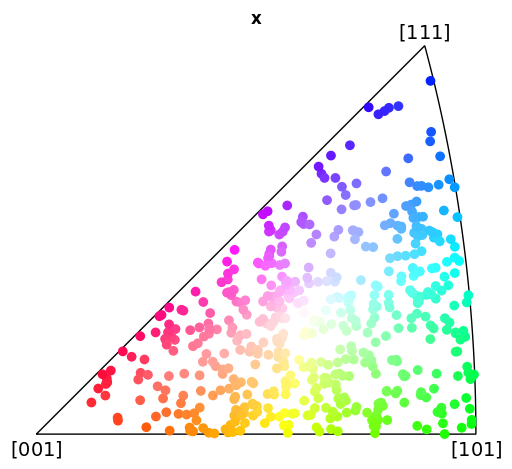

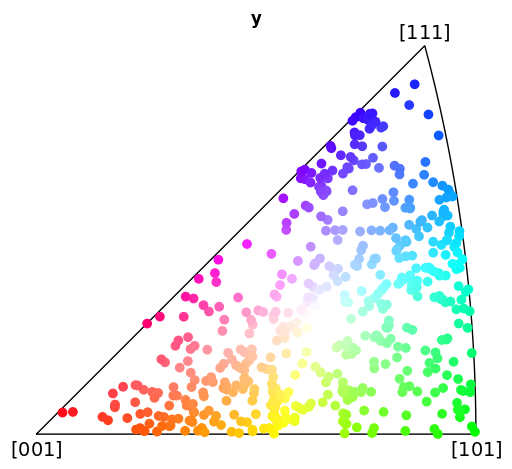

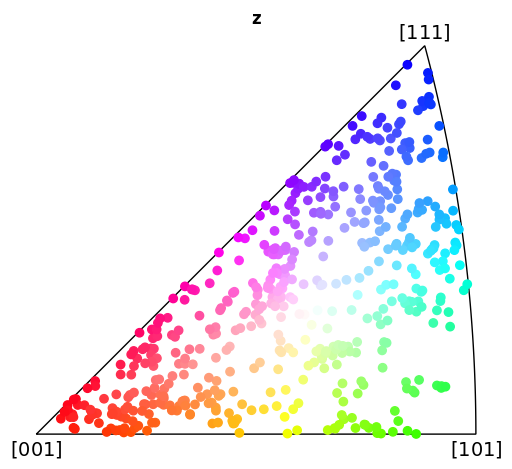

In [10]:
utils.plot_all_ipfs(grains)

## Major phase grains
You inherit the reconstruction parameters you used for your major phase grains : 
- `whole_sample_mask`
- `shift`
- `pad`
- `y0`

In [11]:
major_phase_grainsinos = read_h5(ds.grainsfile, ds, major_phase_strs[0])  # pick one of the major phases
whole_sample_mask = major_phase_grainsinos[0].recon_mask
shift = major_phase_grainsinos[0].recon_shift
pad = major_phase_grainsinos[0].recon_pad
y0 = major_phase_grainsinos[0].recon_y0
print(shift, y0, pad)
if is_half_scan:
    ds.correct_bins_for_half_scan(y0)

8.489598935092346 -15.979204998876389 18


# Filtration
## (optional) remove major phase peaks
- `cf_4d`: all the peaks
- `major_phase_cf_dstol`: it is the tolerance around the predicted reflection from the majorphase where the peaks will be removed.
- `major_phase_unitcells`: unitcell of the major phase

In [12]:
if remove_major_phase_peaks:
    cf_4d = remove_peaks_from_phases(cf_4d, major_phase_cf_dstol, major_phase_unitcells)

## Filter by intensity
Now we are filtering our peaks (`cf_4d`) to select only the strongest ones .
This time, we don't clip via `dsmax`, because we need the higher-angle projections for complete sinograms.  
1. We first filter the peaks in $d^{*}$ to keep only those close to the predicted peaks from the unit cell.  
2. We then sort our peaks by intensity, and take a certain intensity-weighted fraction of them.  

`minor_phase_cf_dstol`: The tolerance in $d^{*}$ between a peak and a predicted reflection. 
`minor_phase_cf_frac`: The intensity fraction: `frac=0.9` keeps 90% of the peak intensity. We recommend that you choose a value close to the 'elbow' of the plot.

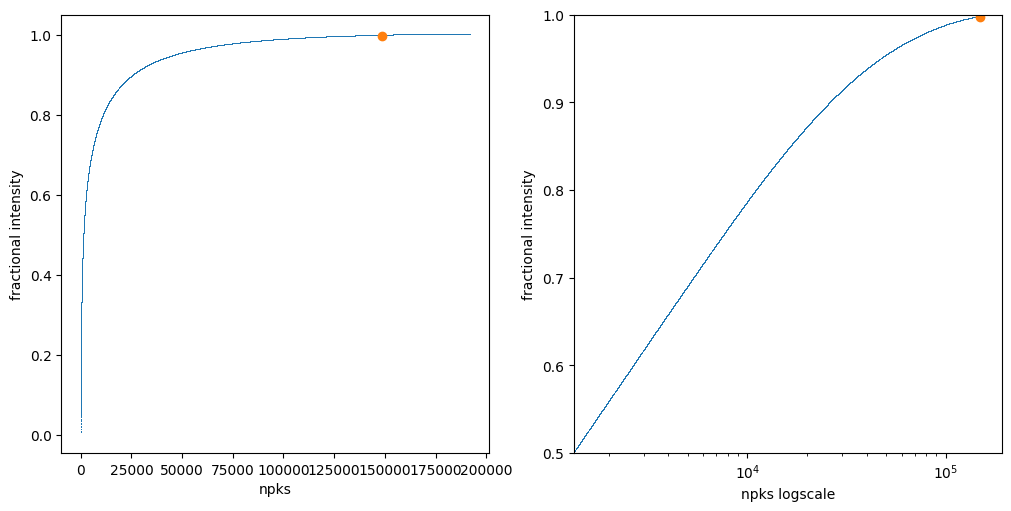

Filtered 148446 peaks from 513331


In [13]:
cf_strong = select_ring_peaks_by_intensity(cf_4d, frac=minor_phase_cf_frac, dstol=minor_phase_cf_dstol, dsmax=cf_4d.ds.max(), ucell=minor_phase_unitcell, doplot=0.5)

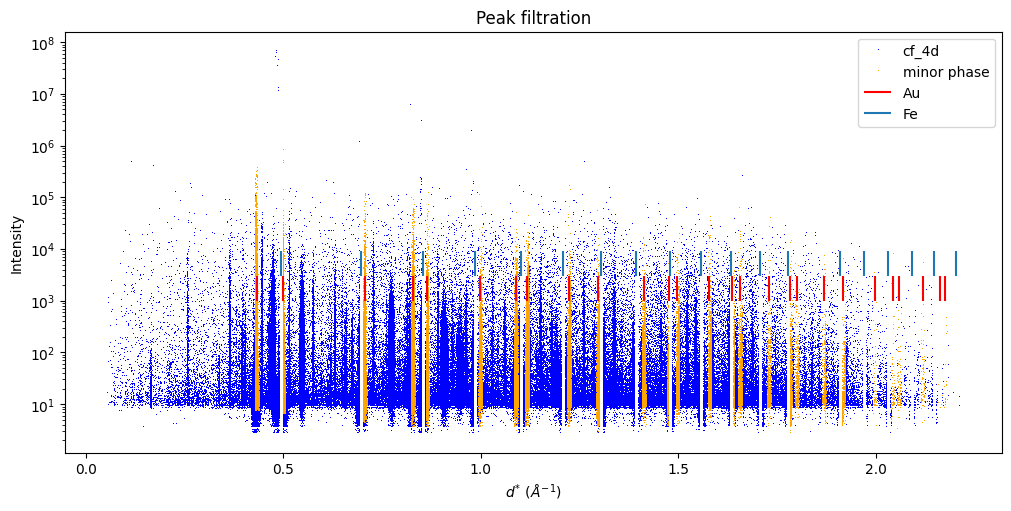

In [14]:
minor_phase_unitcell.makerings(cf_strong.ds.max())
skip = 1  # we can skip peaks to speed up plotting if needed
fig, ax = plt.subplots(figsize=(10, 5), constrained_layout=True)
ax.plot(cf_4d.ds[::skip], cf_4d.sum_intensity[::skip],',', label='cf_4d',c='blue')
ax.plot(cf_strong.ds[::skip], cf_strong.sum_intensity[::skip],',', label='minor phase',c='orange')
ax.vlines(minor_phase_unitcell.ringds, 1e3, 3e3, color='red', label=minor_phase_unitcell.name)
for inc, major_phase_unitcell in enumerate(major_phase_unitcells):
    ax.vlines(major_phase_unitcell.ringds, 3e3*(3**inc), 3e3*(2**inc)*3, color=plt.color_sequences['tab20'][inc], label=major_phase_unitcell.name)
ax.set(xlabel=r'$d^{*}~(\AA^{-1})$', ylabel='Intensity', yscale='log', title='Peak filtration')
ax.legend(loc='upper right')
plt.show()

# Peak assignment

In [15]:
utils.assign_peaks_to_grains(grains, cf_strong, peak_assign_tol)
for grain_label, g in enumerate(grains):
    g.gid = grain_label
    g.npks_4d = np.sum(cf_strong.grain_id == grain_label)

Scoring and assigning 513 grains


  0%|          | 0/513 [00:00<?, ?it/s]

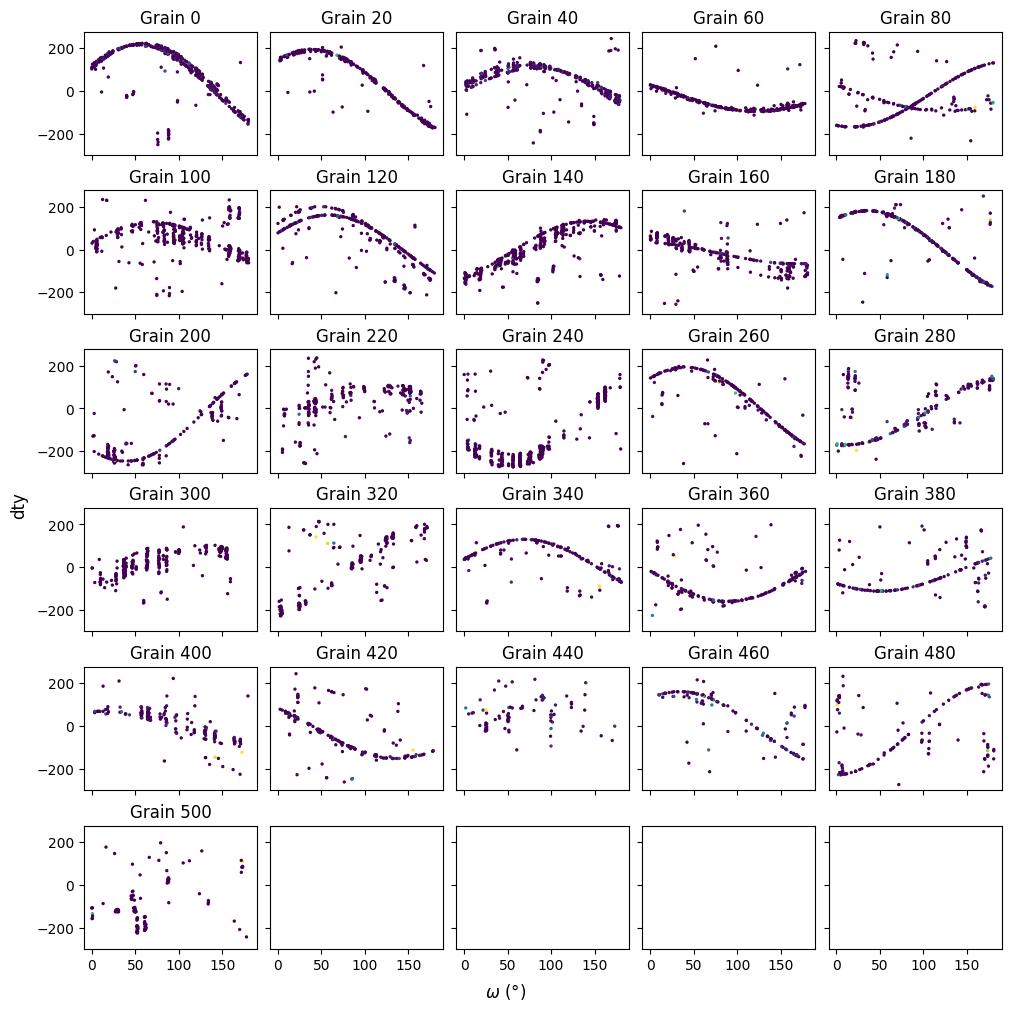

In [16]:
utils.plot_grain_sinograms(grains, cf_strong, min(len(grains), 25))

# Grain position refinement
After filtering out peaks from the major phase, you can visualize the position of all indexed grains. Since a lot of grains were indexed in the previous step, some of the grains may be "false grain" (if they appear outside of the sample for instance).
All these "false grains" will be filtered out during the mapping process (it is also possible to come back to the previous step and improve the indexing).

In [17]:
for grain_label, gs in enumerate(grainsinos):
    gs.update_lab_position_from_peaks(cf_strong, grain_label)

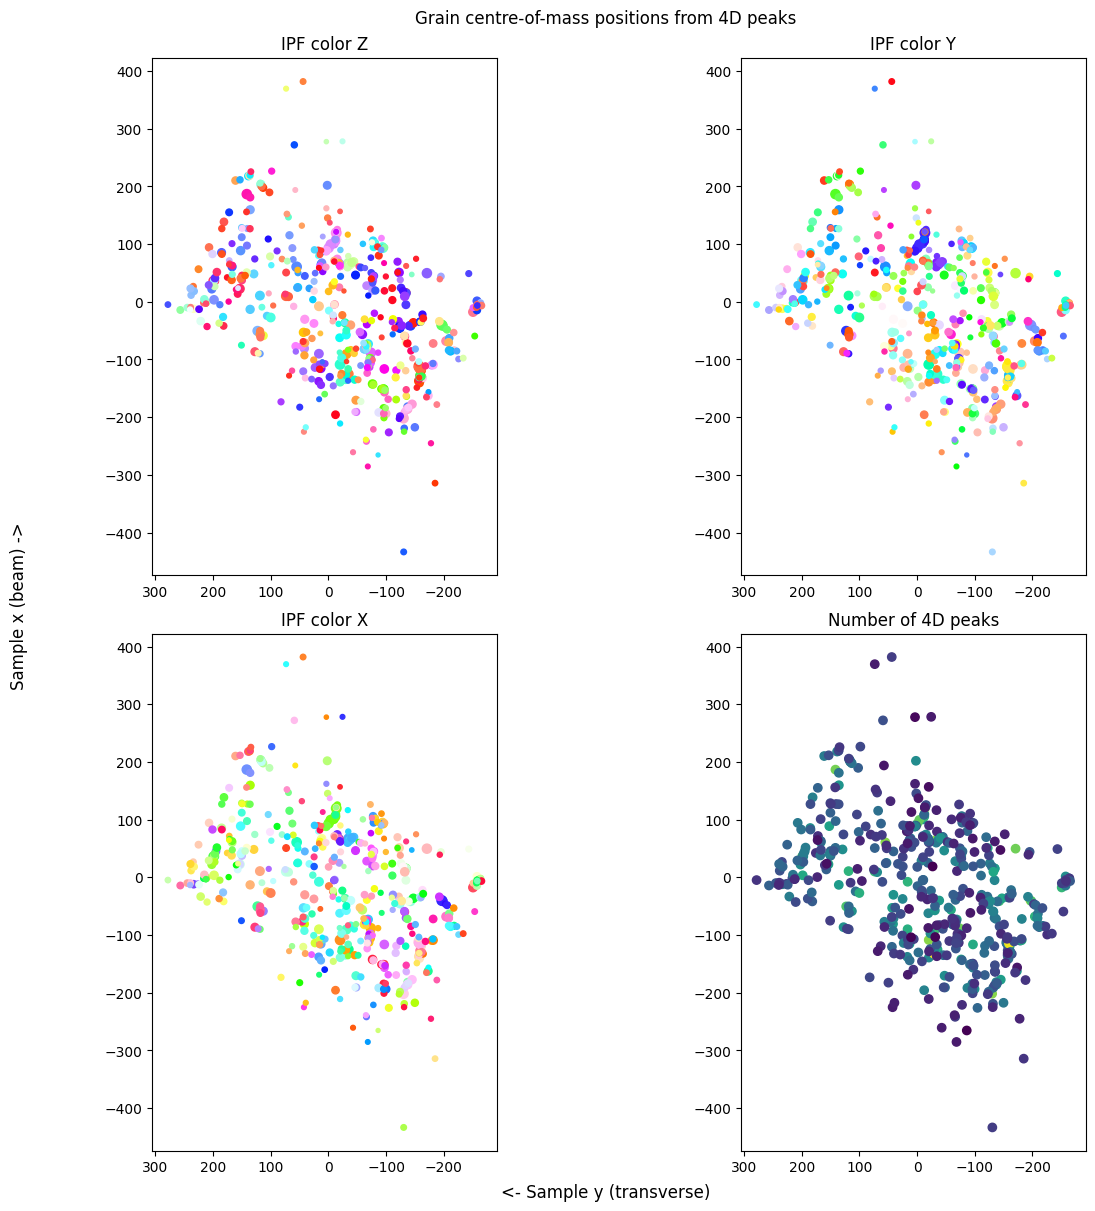

In [18]:
# plt.style.use('dark_background')
fig, ax = plt.subplots(2,2, figsize=(12,12), layout='constrained')
a = ax.ravel()
x = [g.translation[0] for g in grains]
y = [g.translation[1] for g in grains]
s = [g.npks_4d/10 for g in grains]
a[0].scatter(y, x, c=[g.rgb_z for g in grains], s=s)
a[0].set(title='IPF color Z',  aspect='equal')
a[1].scatter(y, x, c=[g.rgb_y for g in grains], s=s)
a[1].set(title='IPF color Y', aspect='equal')
a[2].scatter(y, x, c=[g.rgb_x for g in grains], s=s)
a[2].set(title='IPF color X',  aspect='equal')
a[3].scatter(y, x, c=s)
a[3].set(title='Number of 4D peaks', aspect='equal')
fig.supxlabel("<- Sample y (transverse)")
fig.supylabel("Sample x (beam) ->")
fig.suptitle("Grain centre-of-mass positions from 4D peaks")
for a in ax.ravel():
    a.invert_xaxis()
plt.show()

# Grain sinogram generation

The goal is to reconstruct a sinogram for each grain

In [19]:
gord, inds = get_2d_peaks_from_4d_peaks(ds.pk2d, cf_strong)
for grain_label, gs in enumerate(tqdm(grainsinos)):
    gs.prepare_peaks_from_4d(cf_strong, gord, inds, grain_label, hkltol)

  0%|          | 0/513 [00:00<?, ?it/s]

^ if you segmented frelon data for scanning, the above cell won't work, because we don't have a 2d peaks table
you can instead try the below to prepare the peaks from the 2D peaks:

In [20]:
# cf_2d = ds.get_cf_2d_from_disk()
# ds.update_colfile_pars(cf_2d, phase_str)
# for grain_label, gs in enumerate(tqdm(grainsinos)):
#     gs.prepare_peaks_from_2d(cf_2d, grain_label, hkltol)

In [21]:
for gs in tqdm(grainsinos):
    gs.build_sinogram()

  0%|          | 0/513 [00:00<?, ?it/s]

In [22]:
# optionally correct the halfmask:
if is_half_scan:
    for gs in grainsinos:
        gs.correct_halfmask()

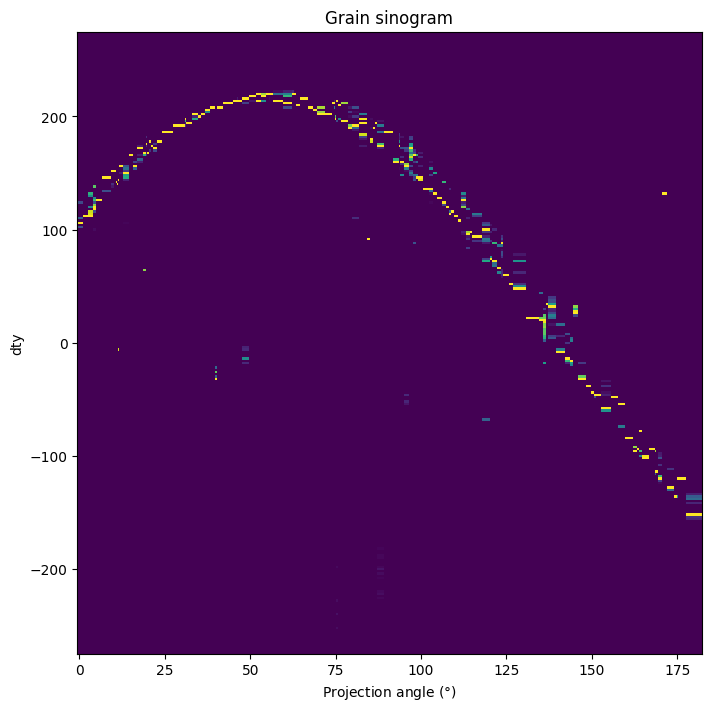

In [23]:
gs = grainsinos[0]
fig, ax = plt.subplots(figsize=(7, 7), layout='constrained')
ax.pcolormesh(gs.sinoangles, ds.ybincens, gs.ssino)
ax.set(xlabel=r'Projection angle ($\degree$)', ylabel='dty', title='Grain sinogram')
plt.show()

We can optionally correct each row of the sinogram by the ring current of that rotation
This helps remove artifacts in the reconstruction

In [24]:
if correct_sinos_with_ring_current:
    ds.get_ring_current_per_scan()
    for gs in grainsinos:
        gs.correct_ring_current(is_half_scan=is_half_scan)

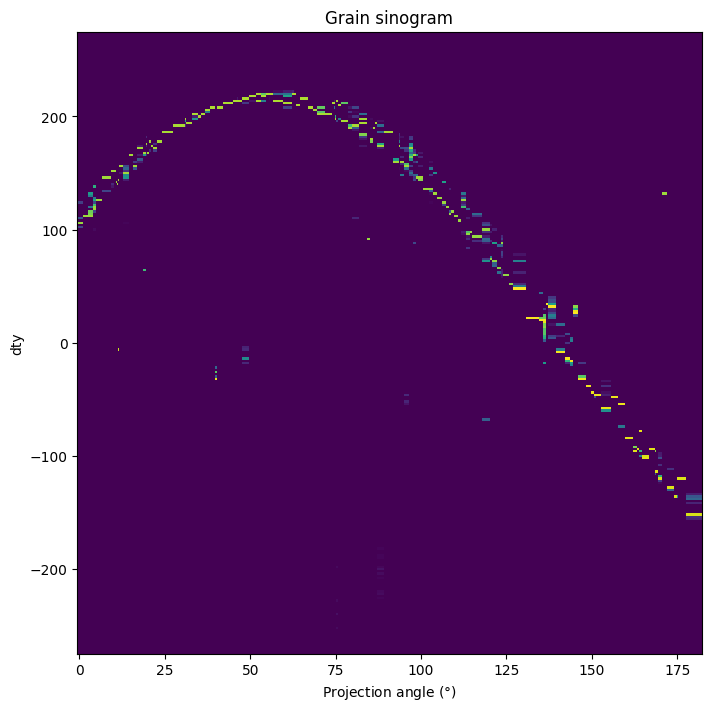

In [25]:
gs = grainsinos[0]
fig, ax = plt.subplots(figsize=(7, 7), layout='constrained')
ax.pcolormesh(gs.sinoangles, ds.ybincens, gs.ssino)
ax.set(xlabel=r'Projection angle ($\degree$)', ylabel='dty', title='Grain sinogram')
plt.show()

# Grain shape reconstruction

By back projecting a sinogram, it is possible to reconstruct the 2D shape of each grain (same principle as tomographic imaging). There are different method to do a back projection, the fastest is using *iradon* from the scipy library.

## iradon
### First grain as example
Check that the reconstruction is satisfying for the first grain. 
There should be a sinogram on the left picture and a reconstruction of the grain on the right. Sometimes the first grain is a very small one, it's okay, streaks might appear on the reconstruction. They will disappear when we will use Astra to reconstruct the grains.

A sign of a bad reconstruction is a completely dark picture. In that case, you might want to check that the mask is correctly loaded (and that it's boolean, True/False, and not 0 and 1):
```
plt.figure()
plt.imshow(whole_sample_mask)
```

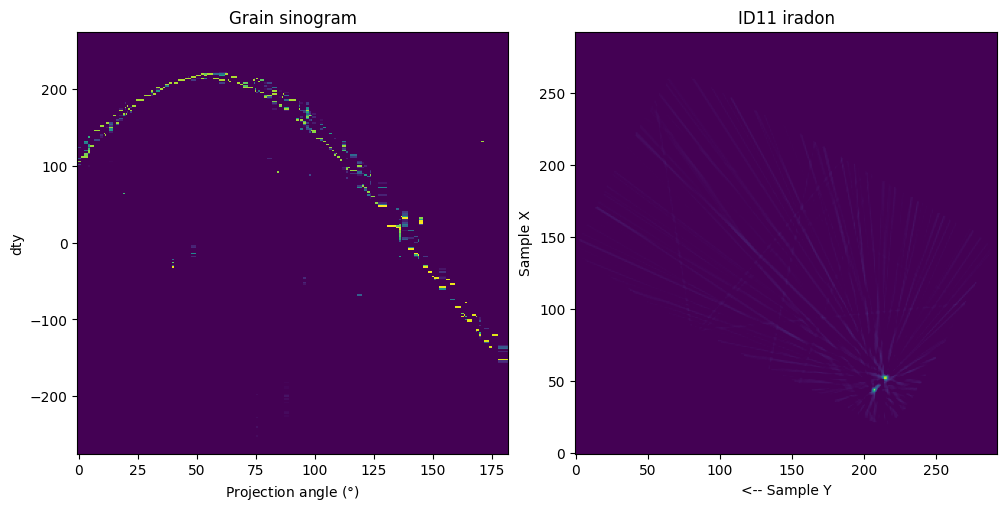

In [26]:
gs.update_recon_parameters(pad=pad, shift=shift, mask=whole_sample_mask, y0=y0)
gs.recon()
if is_half_scan:
    gs.mask_central_zingers("iradon", radius=halfmask_radius)
fig, axs = plt.subplots(1,2, figsize=(10,5), layout="constrained")
axs[0].pcolormesh(gs.sinoangles, ds.ybincens, gs.ssino)
axs[0].set(xlabel=r'Projection angle ($\degree$)', ylabel='dty', title='Grain sinogram')
axs[1].imshow(gs.recons["iradon"], vmin=0, origin="lower")
axs[1].set(title="ID11 iradon", xlabel="<-- Sample Y", ylabel="Sample X")
plt.show()

For every grain, we update the reconstruction parameters : 
- `pad`
- `shift`
- `whole_sample_mask`
- `y0`

In [27]:
for gs in grainsinos:
    gs.update_recon_parameters(pad=pad, shift=shift, mask=whole_sample_mask, y0=y0)

### Reconstruct all grains
In parallel, on as many cpu you have available.

In [28]:
nthreads = cImageD11.cores_available()
with concurrent.futures.ThreadPoolExecutor(max_workers= max(1,nthreads-1)) as pool:
    for i in tqdm(pool.map(GrainSinogram.recon, grainsinos), total=len(grainsinos)):
        pass
if is_half_scan:
    for gs in grainsinos:
        gs.mask_central_zingers("iradon", radius=halfmask_radius)

  0%|          | 0/513 [00:00<?, ?it/s]

### View outputs
You can slide the widget to go through all the reconstructed grains.
If some grains look messy (lots of streak), it's okay, the next reconstruction method Astra will give better results.

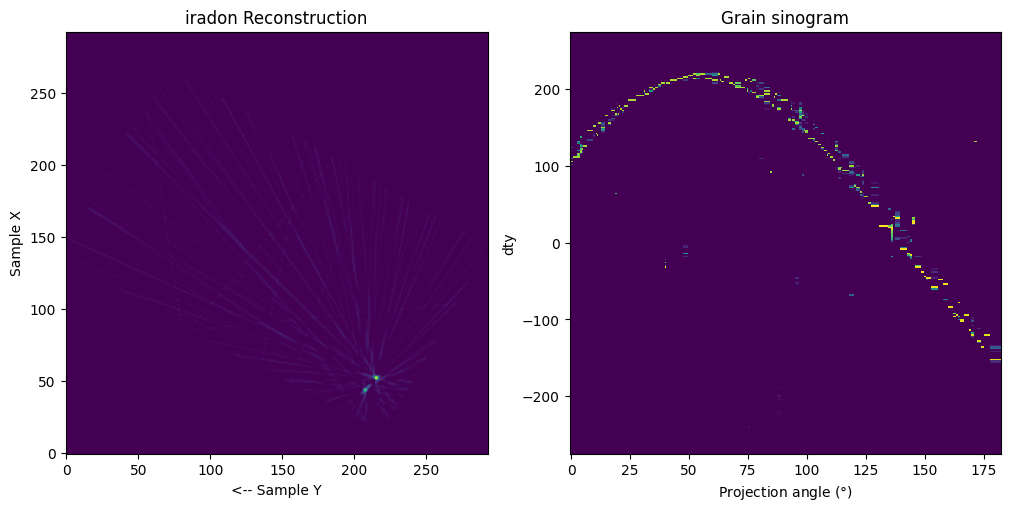

interactive(children=(IntSlider(value=0, description='Grain:', max=512), Output()), _dom_classes=('widget-inte…

In [29]:
def update_frame(i):
    rec.set_array(grainsinos[i].recons["iradon"])
    sin = a[1].pcolormesh(grainsinos[i].sinoangles, ds.ybincens, grainsinos[i].ssino)
    fig.suptitle("Grain " + str(i))
    fig.canvas.draw()
frame_slider = widgets.IntSlider(
    value=0,
    min=0,
    max=len(grains) - 1,
    step=1,
    description='Grain:'
)
fig, a = plt.subplots(1,2,figsize=(10,5), constrained_layout=True)
rec = a[0].imshow(grainsinos[0].recons["iradon"], vmin=0, origin="lower")
sin = a[1].pcolormesh(grainsinos[0].sinoangles, ds.ybincens, grainsinos[0].ssino)
a[0].set(xlabel="<-- Sample Y", ylabel="Sample X", title="iradon Reconstruction")
a[1].set(xlabel=r'Projection angle ($\degree$)', ylabel='dty', title='Grain sinogram')
widgets.interact(update_frame, i=frame_slider)
plt.show()

### Assemble TensorMap
All the grains are assembled together on a single map. It will probably look very messy for small grains.
You can tune the cutoff parameter for a better visualisation : `first_tmap_cutoff_level`

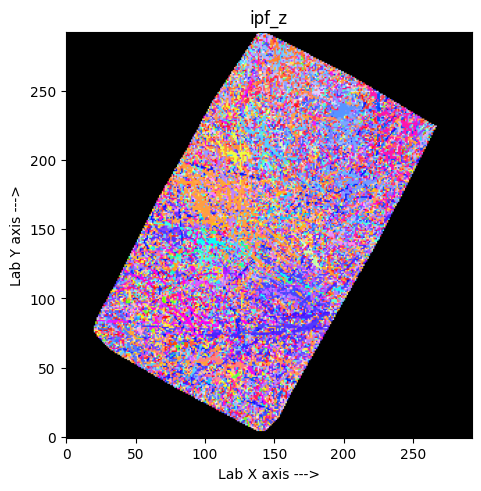

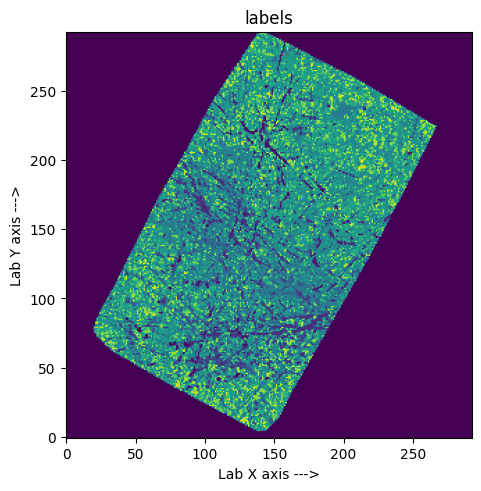

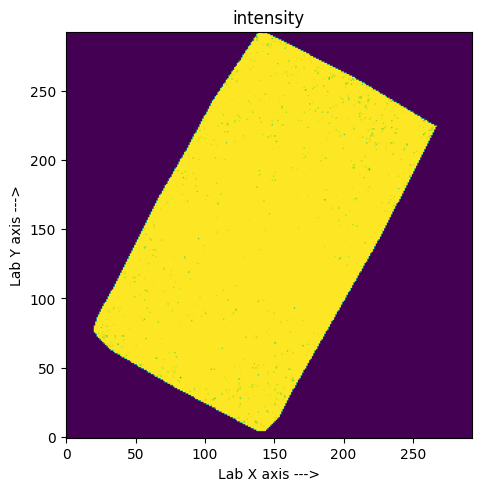

In [30]:
tensor_map = TensorMap.from_grainsinos(grainsinos, cutoff_level=first_tmap_cutoff_level)
tensor_map.plot("ipf_z")
tensor_map.plot("labels")
tensor_map.plot("intensity")

## ASTRA
We can clean up these reconstructions using an MLEM iterative recon.  
We will carry this out using ASTRA (https://astra-toolbox.com/) on the GPU on the SLURM cluster.  
The ASTRA EM_CUDA method will be used.

In [31]:
for gs in grainsinos:
    gs.update_recon_parameters(pad=pad, shift=shift, mask=whole_sample_mask, niter=niter, y0=y0)
write_h5(ds.grainsfile, grainsinos, overwrite_grains=True, group_name=minor_phase_str)

Submit the batch file to the ESRF cluster

In [32]:
bash_script_path = utils.prepare_astra_bash(ds, ds.grainsfile, PYTHONPATH, group_name=minor_phase_str)
utils.slurm_submit_and_wait(bash_script_path, 10)

Submitted batch job 25115746
25115746
Slurm job not finished! Waiting 10 seconds...
Slurm job not finished! Waiting 10 seconds...
Slurm job not finished! Waiting 10 seconds...
Slurm job finished!


In [33]:
grainsinos = read_h5(ds.grainsfile, ds, group_name=minor_phase_str)
for gs, g in zip(grainsinos, grains):
    gs.grain = g
    gs.ds = ds

### View outputs

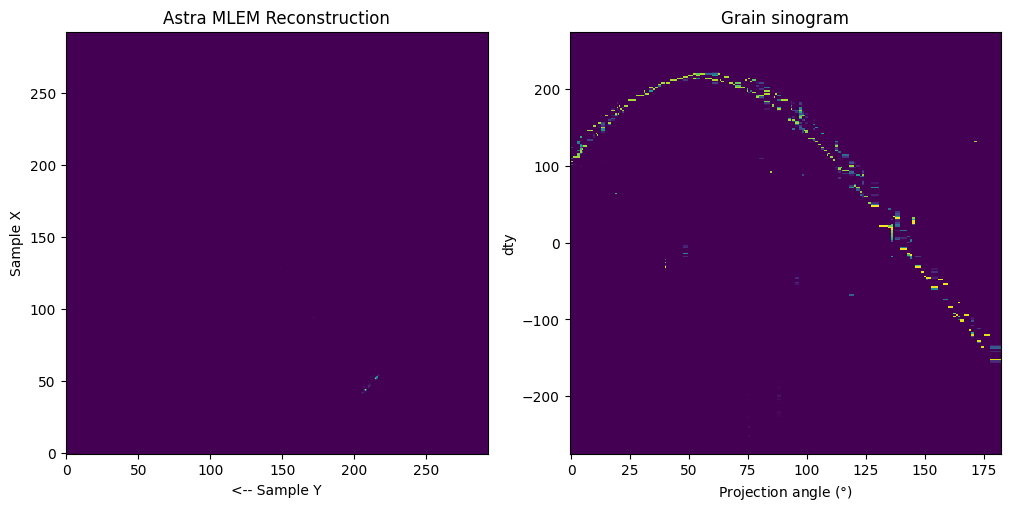

interactive(children=(IntSlider(value=0, description='Grain:', max=512), Output()), _dom_classes=('widget-inte…

In [34]:
def update_frame(i):
    rec.set_array(grainsinos[i].recons["iradon"])
    sin = a[1].pcolormesh(grainsinos[i].sinoangles, ds.ybincens, grainsinos[i].ssino)
    fig.suptitle("Grain " + str(i))
    fig.canvas.draw()
frame_slider = widgets.IntSlider(
    value=0,
    min=0,
    max=len(grains) - 1,
    step=1,
    description='Grain:'
)
fig, a = plt.subplots(1,2,figsize=(10,5), constrained_layout=True)
rec = a[0].imshow(grainsinos[0].recons["astra"], vmin=0, origin="lower")
sin = a[1].pcolormesh(grainsinos[0].sinoangles, ds.ybincens, grainsinos[0].ssino)
a[0].set(xlabel="<-- Sample Y", ylabel="Sample X", title="Astra MLEM Reconstruction")
a[1].set(xlabel=r'Projection angle ($\degree$)', ylabel='dty', title='Grain sinogram')
widgets.interact(update_frame, i=frame_slider)
plt.show()

### Assemble TensorMap

Once again all the ASTRA reconstructed grains are assembled together in a tensormap object.
It should look cleaner than the iradon reconstruction, you can also change the cutoff level with : `second_tmap_cutoff_level`

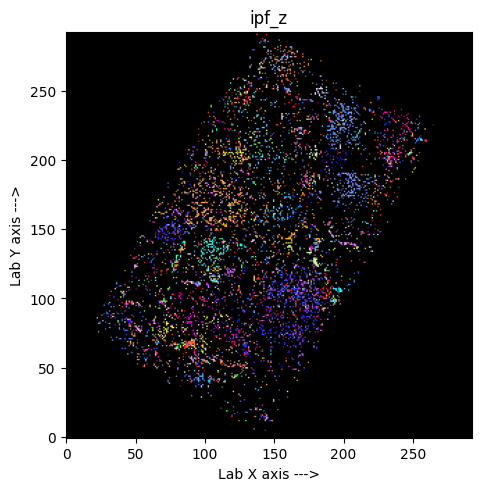

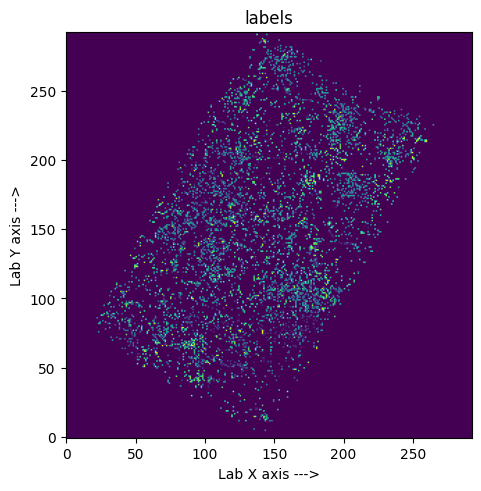

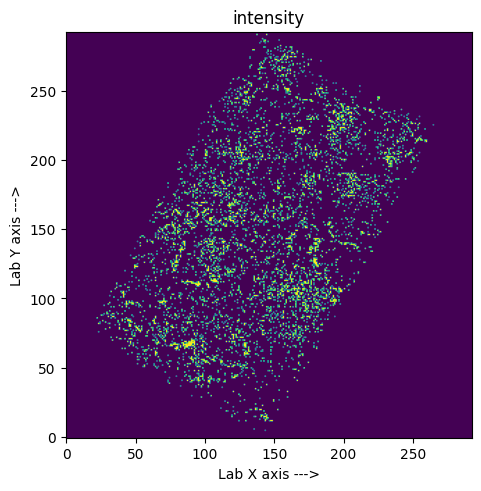

In [35]:
tensor_map_astra = TensorMap.from_grainsinos(grainsinos, cutoff_level=second_tmap_cutoff_level, method="astra")
tensor_map_astra.plot("ipf_z")
tensor_map_astra.plot("labels")
tensor_map_astra.plot("intensity")

# Filter by reconstruction quality  
For weak grains, there will likely be many streaks, indicating a few grains have dodgy reconstructions and are probably not to be trusted.  
To fix this, we can count how many pixels in the grain labels array each grain has.  
It can be helpful to run this filtration more than once.  

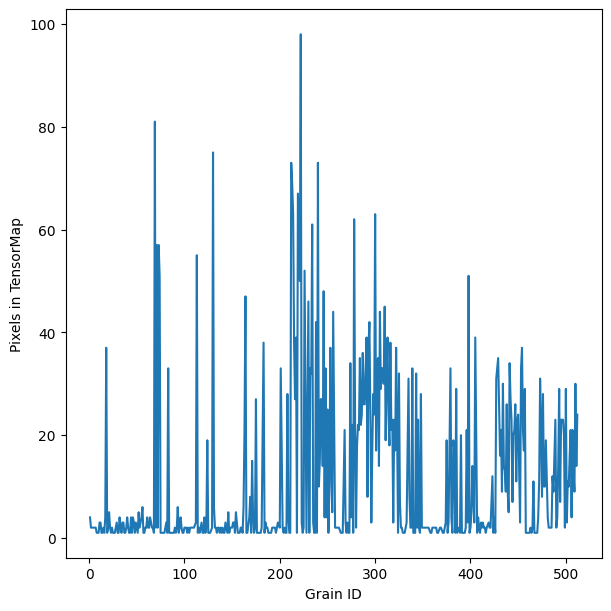

In [36]:
labels, counts = np.unique(tensor_map_astra["labels"], return_counts=True)
fig, ax = plt.subplots(constrained_layout=True, figsize=(6, 6))
ax.plot(labels[labels > 0], counts[labels > 0])
ax.set(xlabel='Grain ID', ylabel='Pixels in TensorMap')
plt.show()

Filter out grains with more than `grain_too_many_px pixels` in the label map.  
This normally indicates a dodgy reconstruction for this grain.  
Only really applies if the grains are very small!

In [37]:
bad_gids = [int(label) for (label, count) in zip(labels, counts) if count > grain_too_many_px and label > 0]
print(f"{len(grainsinos)} grains before filtration")
grainsinos_clean = [gs for (inc, gs) in enumerate(grainsinos) if inc not in bad_gids]
grain_labels_clean = [inc for (inc, gs) in enumerate(grainsinos) if inc not in bad_gids]
print(f"{len(grainsinos_clean)} grains after filtration")
for gs, label in zip(grainsinos_clean, grain_labels_clean):
    gs.grain.gid = label

513 grains before filtration
357 grains after filtration


### Assemble cleaned TensorMap
Now this map should look better than the previous one.

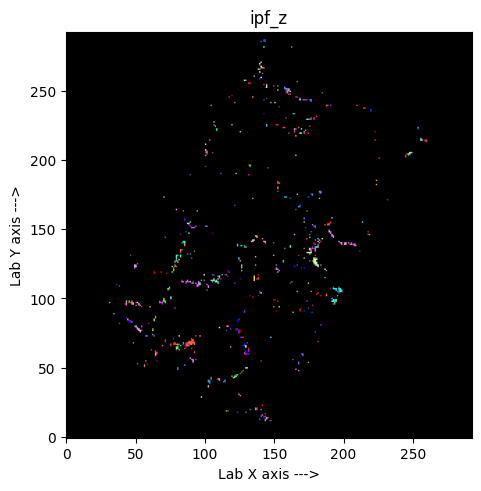

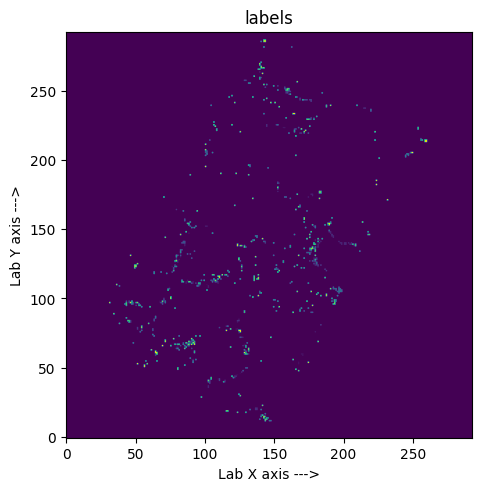

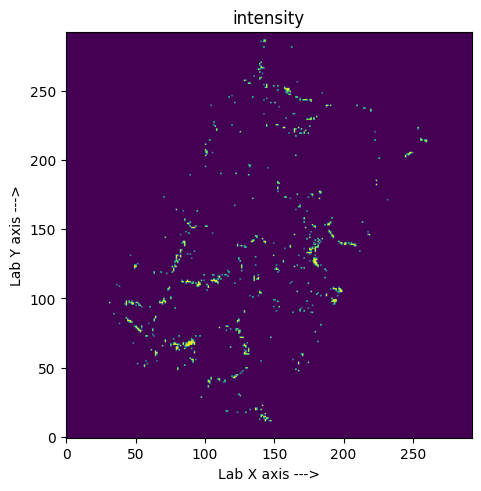

In [38]:
tensor_map_astra = TensorMap.from_grainsinos(grainsinos_clean, cutoff_level=second_tmap_cutoff_level, method="astra")
tensor_map_astra.plot("ipf_z")
tensor_map_astra.plot("labels")
tensor_map_astra.plot("intensity")

### Re-fit grain positions from reconstructions

In [39]:
for gs in tqdm(grainsinos):
    gs.update_lab_position_from_recon()
for gs in grainsinos:
    gs.update_recon_parameters(y0=y0)

  0%|          | 0/513 [00:00<?, ?it/s]

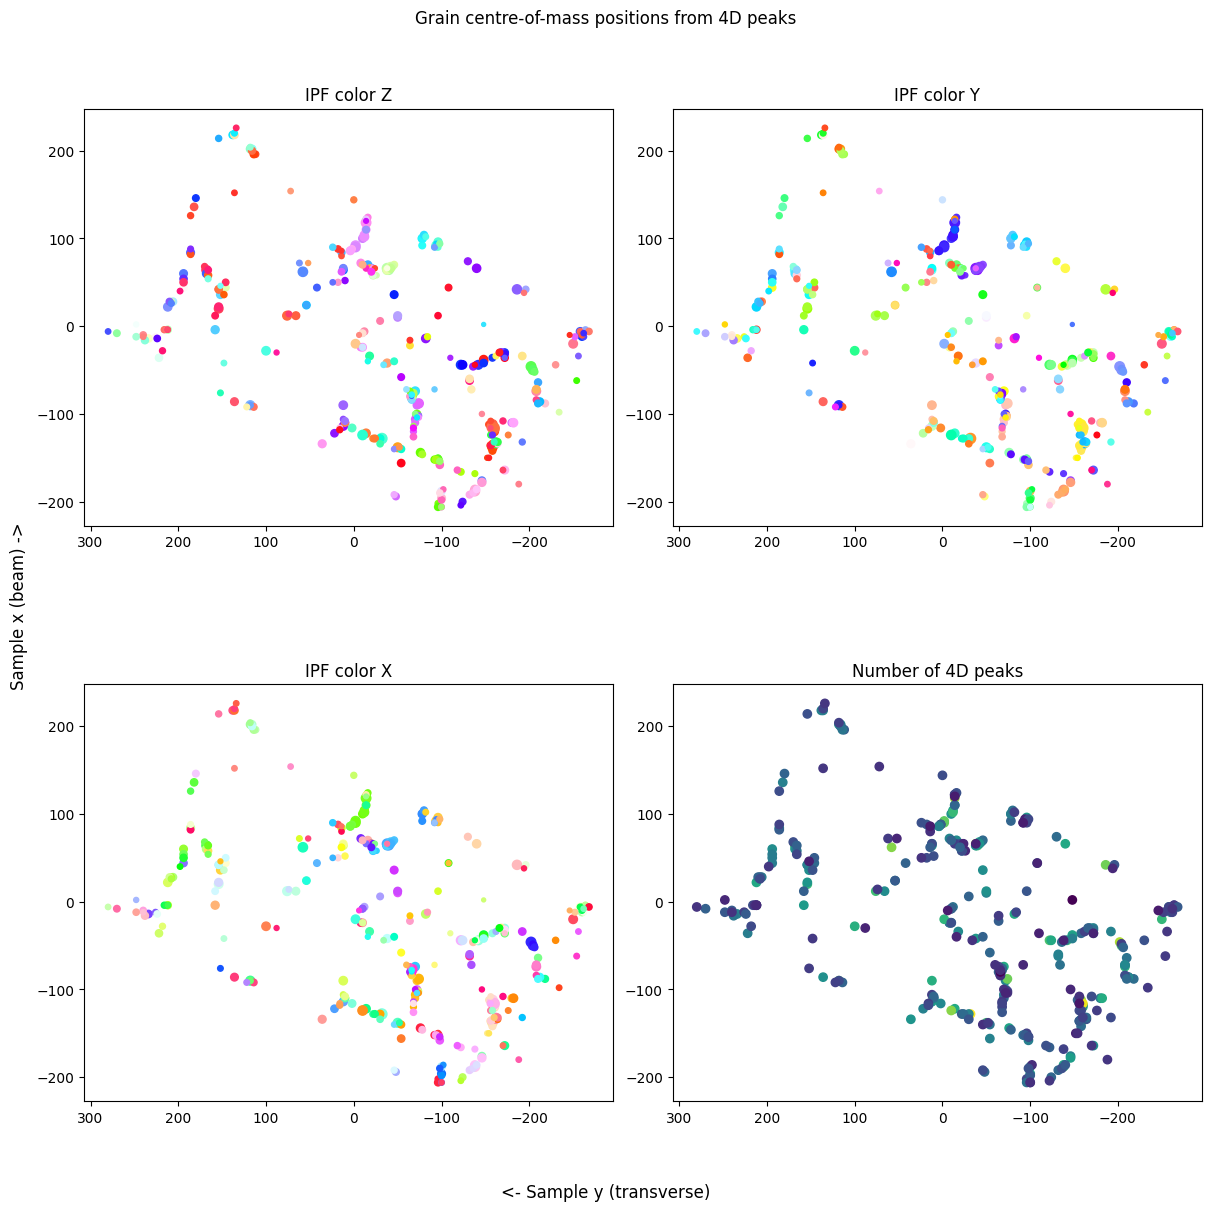

In [40]:
# plt.style.use('dark_background')
fig, ax = plt.subplots(2,2, figsize=(12,12), layout='constrained')
a = ax.ravel()
x = [gs.grain.translation[0] for gs in grainsinos_clean]
y = [gs.grain.translation[1] for gs in grainsinos_clean]
s = [gs.grain.npks_4d/10 for gs in grainsinos_clean]
a[0].scatter(y, x, c=[gs.grain.rgb_z for gs in grainsinos_clean], s=s)
a[0].set(title='IPF color Z',  aspect='equal')
a[1].scatter(y, x, c=[gs.grain.rgb_y for gs in grainsinos_clean], s=s)
a[1].set(title='IPF color Y', aspect='equal')
a[2].scatter(y, x, c=[gs.grain.rgb_x for gs in grainsinos_clean], s=s)
a[2].set(title='IPF color X',  aspect='equal')
a[3].scatter(y, x, c=s)
a[3].set(title='Number of 4D peaks', aspect='equal')
fig.supxlabel("<- Sample y (transverse)")
fig.supylabel("Sample x (beam) ->")
fig.suptitle("Grain centre-of-mass positions from 4D peaks")
for a in ax.ravel():
    a.invert_xaxis()
plt.show()

# Export
If the reconstruction is satisfying, we can save everything to the grain file (*XXX_grains.h5*).
## Grains

If you already ran this notebook once and saved some results, you can not overwrite them.
This will inevitably lead to an error like : 
```
ValueError: Unable to synchronously create group (name already exists)
```

In that case, you can delete the existing grains with these lines of code below.

In [41]:
from ImageD11.forward_model import io
io.delete_group_from_h5(ds.grainsfile, group_name = minor_phase_str)
io.delete_group_from_h5(ds.grainsfile, group_name = 'TensorMap_' + minor_phase_str)

True

In [ ]:
write_h5(ds.grainsfile, grainsinos, overwrite_grains=True, group_name=minor_phase_str)

## TensorMap

In [ ]:
tensor_map_astra.to_h5(ds.grainsfile, h5group='TensorMap_' + minor_phase_str)

## XDMF

In [ ]:
tensor_map_astra.to_paraview(ds.grainsfile, h5group='TensorMap_' + minor_phase_str)

In [ ]:
ds.save()